We try to use FlagRep to represent pieces of the indian pines dataset as flags. Then, we use chordal distance between flags to build a distance matrix. Finally, we use MDS and tSNE to visualize the data distribution in 2 dimensions.

Some details:
- A patch of data is a set of pixels, all of the same class, stacked into the data matrix that is (n-pixels) x (n_bands)
- Collecting patches of the data is either done by neighboring pixels or randomly. Using neighboring pixels results in a non-seniscal MDS visualization. So we prefer random selection.
- We also try collecting all the data from one class into one data matrix. Then visualizing the differences between classes. This is again, not that informative. 


In [15]:
import numpy as np
import scipy

import sys
sys.path.append('../')
from FlagRep import FlagRep

from matplotlib import pyplot as plt

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split



In [16]:
def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

In [17]:
#Train and evaluate kNN classifier with precomputed distances
def evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values):
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        
        # Fit the model using the training distance matrix and labels
        knn.fit(distance_matrix_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(distance_matrix_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")

#Train and evaluate kNN classifier with precomputed distances
def evaluate_knn(data_train, data_test, y_train, y_test, k_values):
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Fit the model using the training distance matrix and labels
        knn.fit(data_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(data_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")

In [18]:
class_names = {1: 'Alfalfa',
               2: 'Corn-notill',
               3: 'Corn-mitill',
               4: 'Corn',
               5: 'Grass-pasture',
               6: 'Grass-trees',
               7: 'Grass-pasture-mowed',
               8: 'Hay-windrowed',
               9: 'Oats',
               10: 'Soybean-notill',
               11: 'Soybean-mitill',
               12: 'Soybean-clean',
               13: 'Wheat',
               14: 'Woods',
               15: 'Buildings-Grass-Trees-Drives',
               16: 'Stone-Steel-Towers'}

In [20]:
## Small example

n=10 # n samples
p=4 # p features

# the feature hierarchy 
A1 = np.array([0])
A2 = np.array([0,1,2])
A3 = np.array([0,1,2,3])

# make a list the feature hierarchy
# this stores indices of the features
Aset = [A1, A2, A3]

# number of trials
n_trials = 1000



seed = 1
    
#set random seed
np.random.seed = seed
    
# randomly generate a data matrix
D = np.zeros((n,p))
D[:,0] = np.random.normal(0,1,n) #d_1
D[:,1] = np.random.normal(0,2,n) #d_2
D[:,2] = 2*D[:,1]                #d_3
D[:,3] = np.random.normal(0,3,n) #d_4

my_flag_rep = FlagRep(Aset)
my_flag_rep.fit_transform(D)

array([[-0.03038557, -0.30136625, -0.27634115],
       [ 0.39109384, -0.31265399, -0.05282075],
       [-0.0786125 , -0.14745146, -0.60468768],
       [ 0.08064526, -0.45866075, -0.03434783],
       [-0.09672653, -0.24350422, -0.01023315],
       [ 0.0044985 ,  0.55009616, -0.07595621],
       [ 0.67282732,  0.06979185,  0.29698531],
       [ 0.42835669,  0.07579742, -0.59414337],
       [-0.2458983 ,  0.32590959, -0.29435422],
       [ 0.35694601,  0.317145  , -0.14245519]])

Playing around...

In [51]:

# Load the hyperspectral image and ground truth
data = sio.loadmat('../../data/indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected']  # Shape: (145, 145, 220)
labels = sio.loadmat('../../data/indian_pines/Indian_pines_gt.mat')['indian_pines_gt']  # Shape: (145, 145)

def extract_patches_of_class(data, labels, patch_size, target_class):
    """
    Extract non-overlapping patches where all pixels in the patch are of the target class.

    :param data: The hyperspectral image data 
    :param labels: The ground truth labels 
    :param patch_size: Size of the patch (e.g., 7 for 7x7 patches).
    :param target_class: The class for which patches should be extracted.
    :return: A list of patches (each patch is of size patch_size x patch_size x num_bands).
    """
    half_patch = patch_size // 2
    patches = []
    patch_labels = []

    # Iterate through the image in steps of patch_size to avoid overlap
    for i in range(half_patch, data.shape[0] - half_patch, patch_size):
        for j in range(half_patch, data.shape[1] - half_patch, patch_size):
            # Extract the patch from both the data and the labels
            label_patch = labels[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1]
            
            # Check if all pixels in the label patch are of the target class
            if np.all(label_patch == target_class):
                # Extract the corresponding data patch
                patch = data[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1, :]
                patches.append(patch)
                patch_labels.append(target_class)

    return np.array(patches), np.array(patch_labels)




# Example usage
patch_size = 11
target_class = 2  # For example, class 2 represents a certain crop type
patches, patch_labels = extract_patches_of_class(data, labels, patch_size, target_class)

print(f"Extracted {len(patches)} patches where all pixels are of class {target_class}. Each patch has shape {patches[0].shape}.")

Extracted 1 patches where all pixels are of class 2. Each patch has shape (11, 11, 200).


In [52]:
mod_data = []
mod_labels = []
for target_class in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]: #[8,10,11,14]:#[8,10,11,14]:#:
    patches, patch_labels = extract_patches_of_class(data, labels, patch_size, target_class)
    if len(patches) > 0:
        flat_patches = [patch.reshape(patch_size**2,200) for patch in patches]
        mod_labels +=[target_class]*len(patches)
        mod_data += flat_patches

    print(f"Extracted {len(patches)} patches where all pixels are of class {target_class}. Each patch has shape {patch_size}.")

Extracted 0 patches where all pixels are of class 1. Each patch has shape 11.
Extracted 1 patches where all pixels are of class 2. Each patch has shape 11.
Extracted 0 patches where all pixels are of class 3. Each patch has shape 11.
Extracted 0 patches where all pixels are of class 4. Each patch has shape 11.
Extracted 0 patches where all pixels are of class 5. Each patch has shape 11.
Extracted 0 patches where all pixels are of class 6. Each patch has shape 11.
Extracted 0 patches where all pixels are of class 7. Each patch has shape 11.
Extracted 1 patches where all pixels are of class 8. Each patch has shape 11.
Extracted 0 patches where all pixels are of class 9. Each patch has shape 11.
Extracted 1 patches where all pixels are of class 10. Each patch has shape 11.
Extracted 4 patches where all pixels are of class 11. Each patch has shape 11.
Extracted 0 patches where all pixels are of class 12. Each patch has shape 11.
Extracted 0 patches where all pixels are of class 13. Each pa

In [53]:
mod_data[0].shape

(121, 200)

Text(0, 0.5, 'PC2')

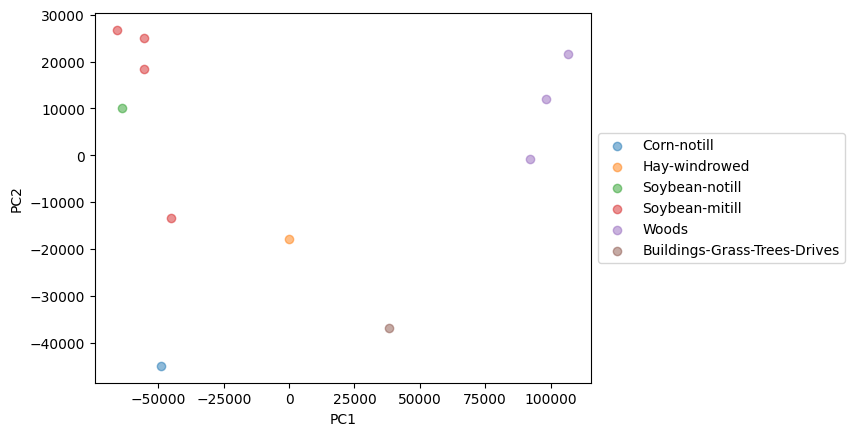

In [54]:
pca = PCA(n_components = 2)
vis_data = pca.fit_transform(np.vstack([m.flatten() for m in mod_data]))

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('PC1')
plt.ylabel('PC2')

In [55]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
vis_data_train, vis_data_test, y_train, y_test = train_test_split(vis_data, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)


# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn(vis_data_train, vis_data_test, y_train, y_test, k_values)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [61]:
Aset = [np.arange(40),np.arange(100)]
mod_flags = []
mod_f_types = []
for pt in mod_data:
    my_flag_rep = FlagRep(Aset)
    flag_pt = my_flag_rep.fit_transform(pt[:,:100])
    f_type = my_flag_rep.flag_type()
    mod_flags.append(flag_pt)
    mod_f_types.append(f_type)


In [70]:
mod_flags

[array([[-8.83842608e-02, -2.05613987e-02,  6.35282134e-02, ...,
         -5.81542202e-02,  8.08986322e-02, -4.40374197e-02],
        [-7.97871095e-02, -1.38467799e-01, -1.26100019e-01, ...,
          2.64525598e-02, -5.56557368e-02,  2.71722319e-02],
        [-7.63443820e-02, -1.09129075e-01, -9.86937835e-03, ...,
          6.10572723e-03,  3.65000099e-02, -4.83130432e-02],
        ...,
        [-1.13014174e-01,  1.49439938e-01, -6.61212982e-02, ...,
         -2.24697634e-01, -1.30765727e-01,  6.38425647e-05],
        [-1.12336696e-01,  1.46139975e-01, -6.32664363e-02, ...,
         -2.45042175e-02,  2.89035749e-02,  7.65823652e-02],
        [-1.10947472e-01,  1.37361606e-01, -5.03567421e-02, ...,
          5.35360711e-03,  3.89253679e-02, -2.47767289e-02]]),
 array([[-0.08786985,  0.14961124, -0.16180978, ...,  0.01513864,
          0.01610677,  0.02292265],
        [-0.08816937,  0.14007493, -0.15109912, ..., -0.05710816,
          0.07800382, -0.02774708],
        [-0.08854659,  0.

In [62]:
def chordal_distance(X, Y, Bs_x, Bs_y):

    k = len(Bs_x)

    dist = 0

    for i in range(k):
        id_x = Bs_x[i]
        id_y = Bs_y[i]
        Xi = X[:,id_x]
        Yi = Y[:,id_y]
        mm = np.min([len(Bs_x[i]), len(Bs_y[i])])
        sin_sq = mm - np.trace(Xi.T @ Yi @ Yi.T @ Xi)
        if np.isclose(sin_sq,0):
            sin_sq = 0
        elif sin_sq < 0:
            print('sine squared less than 0')
            print(sin_sq)
        
        dist = dist + np.sqrt(sin_sq)

    return dist

In [63]:
mod_f_types

[array([40, 99]),
 array([ 40, 100]),
 array([39, 98]),
 array([ 40, 100]),
 array([39, 99]),
 array([40, 99]),
 array([39, 98]),
 array([40, 99]),
 array([39, 99]),
 array([ 40, 100]),
 array([39, 99])]

In [64]:
mod_f_types = [[39,98] for i in range(len(mod_f_types))]

In [65]:
p = len(mod_f_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = mod_flags[i]
        y = mod_flags[j]
        fl_type_x = mod_f_types[i]
        fl_type_y = mod_f_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist
        

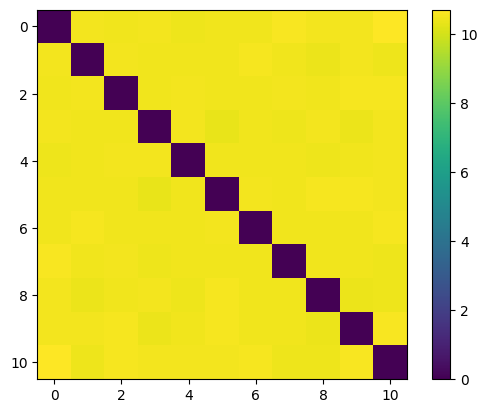

In [66]:
plt.imshow(dist_mat)
plt.colorbar()

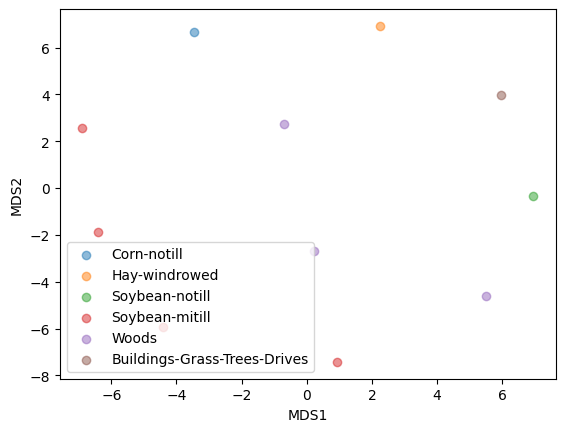

In [67]:
classes = np.unique(labels)

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.legend()

Text(0, 0.5, 't-SNE2')

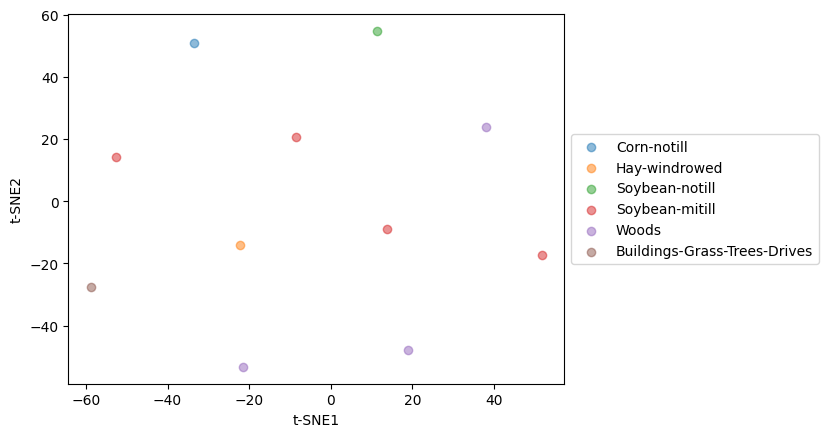

In [69]:

tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10, perplexity=10)
vis_data = tsne.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

In [41]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)

distance_matrix_train = dist_mat[train_indices,:][:,train_indices]
distance_matrix_test = dist_mat[test_indices,:][:,train_indices]
y_train = mod_labels[train_indices]
y_test = mod_labels[test_indices]

# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)


k=1, Accuracy: 0.9730
k=3, Accuracy: 0.8176
k=5, Accuracy: 0.7635
k=7, Accuracy: 0.7770


In [42]:


n_sing_vals = 30#np.max(np.vstack(mod_f_types))

mod_svds = []
svd_f_types = []
for x in mod_data:
    U,_,_ = np.linalg.svd(x)
    mod_svds.append(U[:,:n_sing_vals])
    svd_f_types.append(list(np.arange(1,n_sing_vals+1)))

In [43]:
p = len(mod_f_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = mod_svds[i]
        y = mod_svds[j]
        fl_type_x = svd_f_types[i]
        fl_type_y = svd_f_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist
        

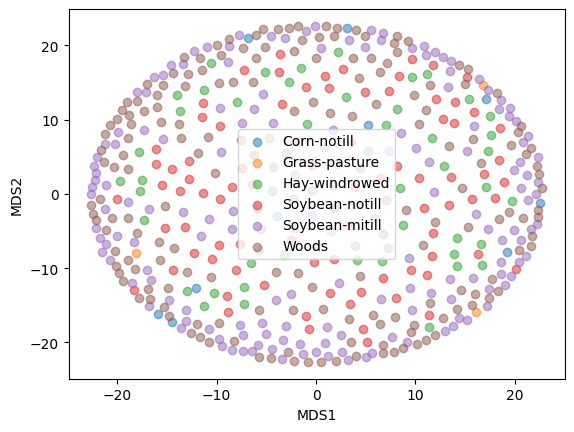

In [44]:
classes = np.unique(labels)

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.legend()

Text(0, 0.5, 't-SNE2')

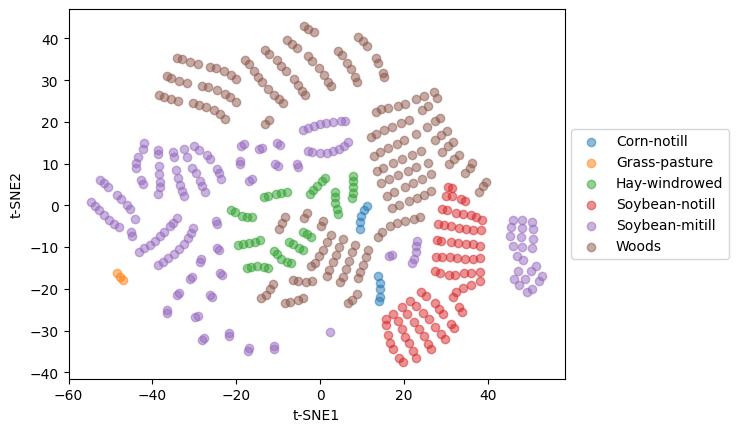

In [45]:

tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
vis_data = tsne.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

In [46]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)

distance_matrix_train = dist_mat[train_indices,:][:,train_indices]
distance_matrix_test = dist_mat[test_indices,:][:,train_indices]
y_train = mod_labels[train_indices]
y_test = mod_labels[test_indices]

# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)


k=1, Accuracy: 1.0000
k=3, Accuracy: 1.0000
k=5, Accuracy: 1.0000
k=7, Accuracy: 0.9797


In [90]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
vis_data_train, vis_data_test, y_train, y_test = train_test_split(vis_data, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)


# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn(vis_data_train, vis_data_test, y_train, y_test, k_values)


k=1, Accuracy: 0.9943
k=3, Accuracy: 0.9830
k=5, Accuracy: 0.9688
k=7, Accuracy: 0.9603


Indian pines experiments

In [15]:
# grass pasture = 5
# corn notill = 2
# data from https://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes#Indian_Pines


data = scipy.io.loadmat('../data/indian_pines/Indian_pines.mat')
labels = scipy.io.loadmat('../data/indian_pines/Indian_pines_gt.mat')

In [16]:
classes = [2,3,4,5,6,8,10,11,12,13,14,15]

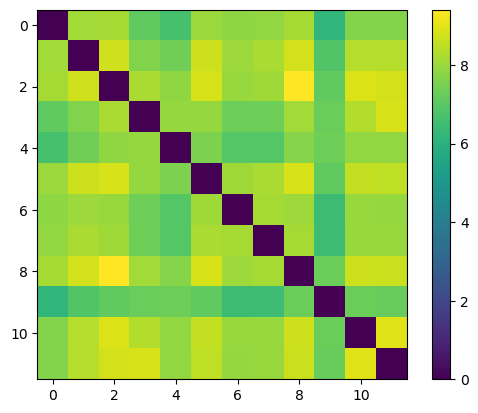

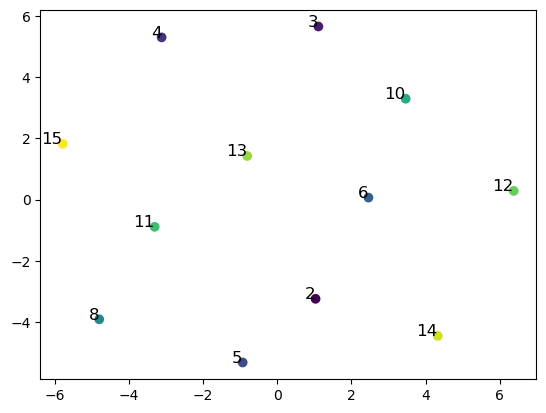

In [17]:
Aset = [np.arange(10),np.arange(30),np.arange(100)]
np.random.seed = 420

n_samples = 200

Xs = []
fl_types = []

for c in classes:
    idx = (labels['indian_pines_gt'] == c)
    sel_data = data['indian_pines'][idx]
    x = sel_data[np.random.choice(len(sel_data), size = n_samples),:]
    X, fl_type = FlagRep(x, Aset, eps_rank=1000)
    Xs.append(X)
    fl_types.append(fl_type)

p = len(fl_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = Xs[i]
        y = Xs[j]
        fl_type_x = fl_types[i]
        fl_type_y = fl_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist

plt.figure()
plt.imshow(dist_mat)
plt.colorbar()


mds = MDS(n_components=2, dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

plt.figure()
plt.scatter(vis_data[:,0], vis_data[:,1],c = classes)

# Add labels to the points
for i in range(len(classes)):
    plt.text(vis_data[:,0][i], vis_data[:,1][i], classes[i], fontsize=12, ha='right')




In [18]:
fl_types

[array([ 4,  8, 31]),
 array([ 5, 11, 33]),
 array([ 5, 14, 41]),
 array([ 5, 18, 31]),
 array([ 5, 14, 24]),
 array([ 5, 12, 33]),
 array([ 5,  9, 28]),
 array([ 5,  9, 29]),
 array([ 5, 13, 38]),
 array([ 5, 13, 20]),
 array([ 5, 14, 32]),
 array([ 5, 21, 39])]

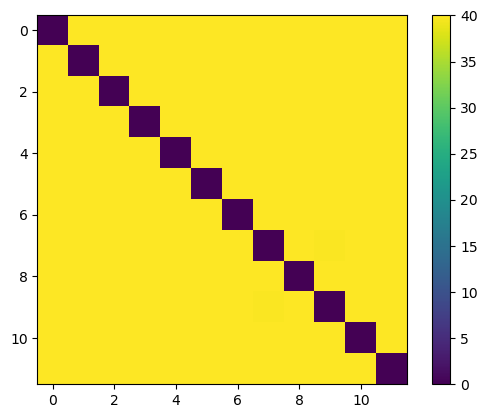

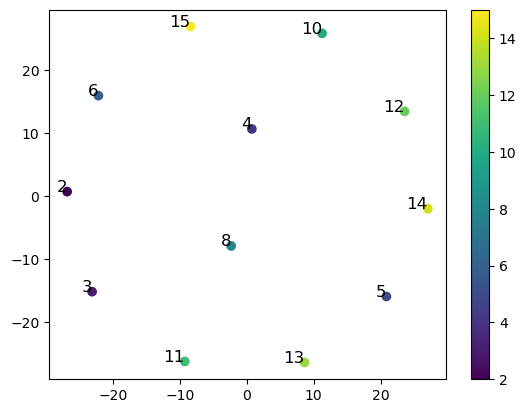

In [19]:
max_dim = np.max(np.vstack(fl_types))
fl_type = list(np.arange(1,max_dim+1))

np.random.seed = 420

n_samples = 200

Xs = []
fl_types = []

for c in classes:
    idx = (labels['indian_pines_gt'] == c)
    sel_data = data['indian_pines'][idx]
    x = sel_data[np.random.choice(len(sel_data), size = n_samples),:]
    U,_,_ = np.linalg.svd(x)
    X = U[:,:max_dim]
    Xs.append(X)
    fl_types.append(fl_type)

p = len(fl_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = Xs[i]
        y = Xs[j]
        fl_type_x = fl_types[i]
        fl_type_y = fl_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist

plt.figure()
plt.imshow(dist_mat)
plt.colorbar()


mds = MDS(n_components=2, dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

plt.figure()
plt.scatter(vis_data[:,0], vis_data[:,1], c = classes)
plt.colorbar()

# Add labels to the points
for i in range(len(classes)):
    plt.text(vis_data[:,0][i], vis_data[:,1][i], classes[i], fontsize=12, ha='right')

Separate between two classes

In [90]:
# grass pasture = 5
# corn notill = 2
# data from https://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes#Indian_Pines


data = scipy.io.loadmat('../data/indian_pines/Indian_pines.mat')
labels = scipy.io.loadmat('../data/indian_pines/Indian_pines_gt.mat')

In [91]:
classes = [2,5,6,8,10,11,12,14,15] #,8,9,10,11,12,14]


n_pts = 30

In [92]:
idx = labels['indian_pines_gt'] == classes[0]
print(labels['indian_pines_gt'][idx])
for c in classes[1:]:
    idx = idx + (labels['indian_pines_gt'] == c) #CHECK THIS!
    print(labels['indian_pines_gt'][idx])

[2 2 2 ... 2 2 2]
[5 5 5 ... 5 5 5]
[5 5 5 ... 5 5 5]
[5 5 5 ... 5 5 5]
[ 5  5 10 ... 10 10 10]
[11 11 11 ... 10 10 10]
[11 11 11 ... 10 10 10]
[11 11 11 ... 10 10 10]
[15 15 15 ... 10 10 10]


In [93]:
sel_data = data['indian_pines'][idx]
sel_labels = labels['indian_pines_gt'][idx]

Text(0, 0.5, 'PC2')

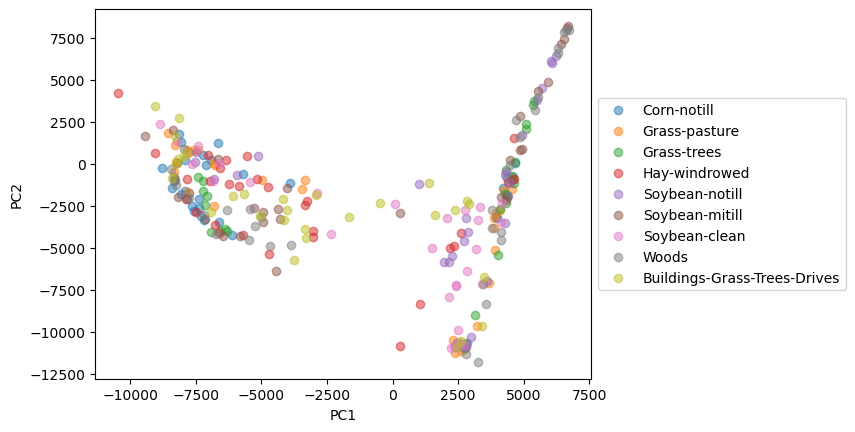

In [94]:

pca = PCA(n_components = 2)
vis_data = pca.fit_transform(sel_data)

n_classes = len(classes)
for i, c in enumerate(classes):
    plt.scatter(vis_data[i*n_pts:(i+1)*n_pts,0],vis_data[i*n_pts:(i+1)*n_pts,1], label = class_names[c], alpha=.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('PC1')
plt.ylabel('PC2')

In [95]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# sel_data = ss.fit_transform(sel_data)

In [96]:
np.random.seed = 420

Aset = [np.arange(10),np.arange(30),np.arange(100)]

Xs = []
fl_types = []
mod_labels = []
k=100
for id in classes:
    idx = sel_labels == id
    for i in range(n_pts):
        x_sel = sel_data[idx]
        x = x_sel[np.random.choice(len(x_sel), size = k),:]
        X, fl_type = FlagRep(x,Aset, eps_rank=1300)
        Xs.append(X)
        fl_types.append(fl_type)
        mod_labels.append(id)


In [97]:
max_dim = np.max(np.vstack(fl_types))

In [98]:
p = len(fl_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = Xs[i]
        y = Xs[j]
        fl_type_x = fl_types[i]
        fl_type_y = fl_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist
        

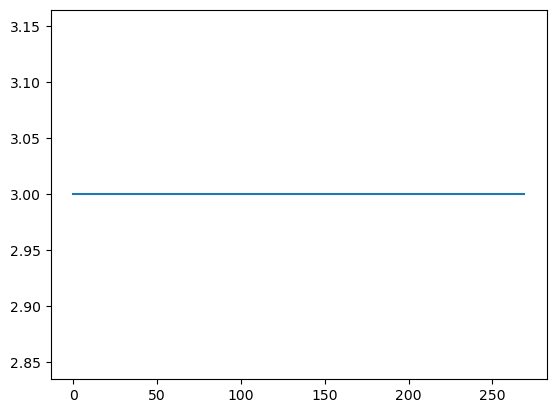

In [99]:
plt.plot([len(f) for f in fl_types])

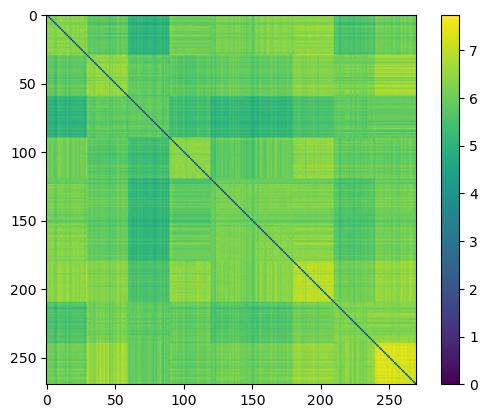

In [100]:
plt.imshow(dist_mat)
plt.colorbar()

Text(0, 0.5, 'MDS2')

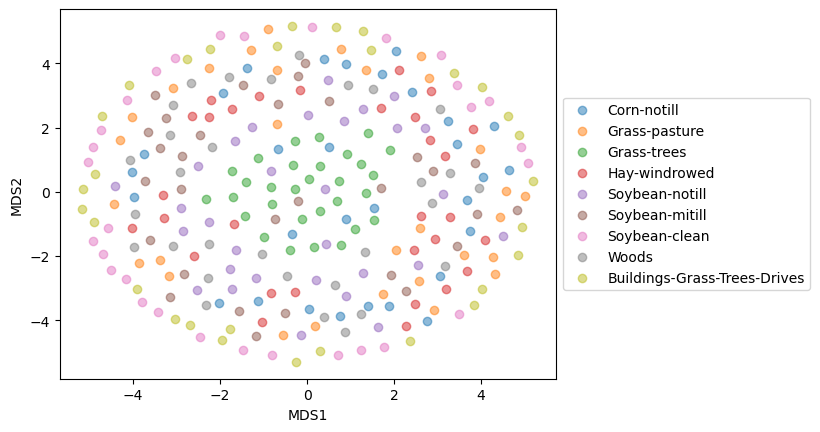

In [101]:

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

n_classes = len(classes)
for i, c in enumerate(classes):
    plt.scatter(vis_data[i*n_pts:(i+1)*n_pts,0],vis_data[i*n_pts:(i+1)*n_pts,1], label = class_names[c], alpha=.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('MDS1')
plt.ylabel('MDS2')

Text(0, 0.5, 't-SNE2')

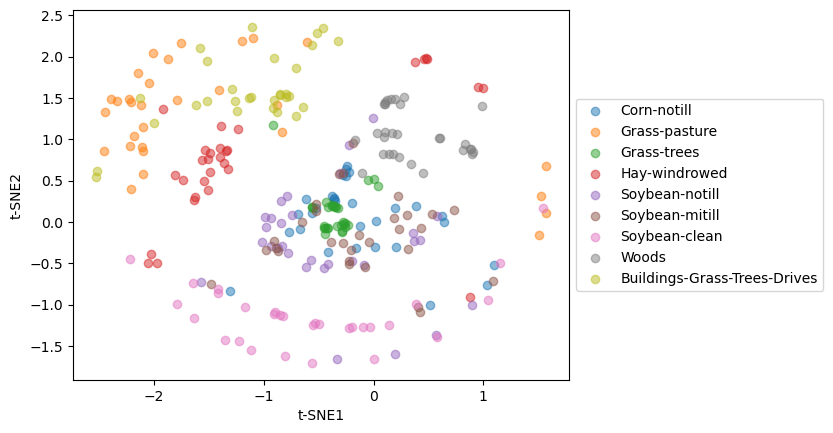

In [102]:

tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
vis_data = tsne.fit_transform(dist_mat)

n_classes = len(classes)
for i, c in enumerate(classes):
    plt.scatter(vis_data[i*n_pts:(i+1)*n_pts,0],vis_data[i*n_pts:(i+1)*n_pts,1], label = class_names[c], alpha=.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

In [103]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)

distance_matrix_train = dist_mat[train_indices,:][:,train_indices]
distance_matrix_test = dist_mat[test_indices,:][:,train_indices]
y_train = mod_labels[train_indices]
y_test = mod_labels[test_indices]

# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)


k=1, Accuracy: 0.0000
k=3, Accuracy: 0.0000
k=5, Accuracy: 0.0000
k=7, Accuracy: 0.0000


In [104]:
n_sing_vals = max_dim

np.random.seed = 420

Xs = []
fl_types = []
k=100
for id in classes:
    idx = sel_labels == id
    for i in range(n_pts):
        x_sel = sel_data[idx]
        x = x_sel[np.random.choice(len(x_sel), size = k),:]
        U,_,_ = np.linalg.svd(x, full_matrices=False)
        Xs.append(U[:,:n_sing_vals])
        fl_types.append(list(np.arange(1,n_sing_vals+1)))

In [105]:
p = len(fl_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = Xs[i]
        y = Xs[j]
        fl_type_x = fl_types[i]
        fl_type_y = fl_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist
        

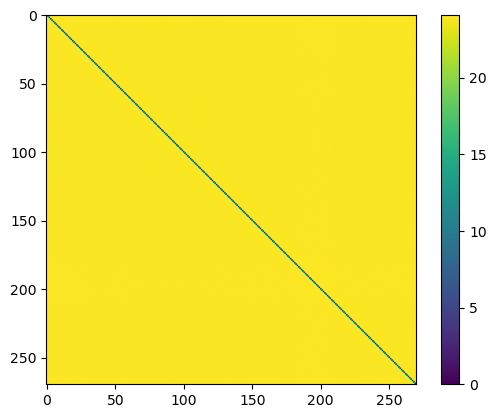

In [106]:
plt.imshow(dist_mat)
plt.colorbar()

Text(0, 0.5, 'MDS2')

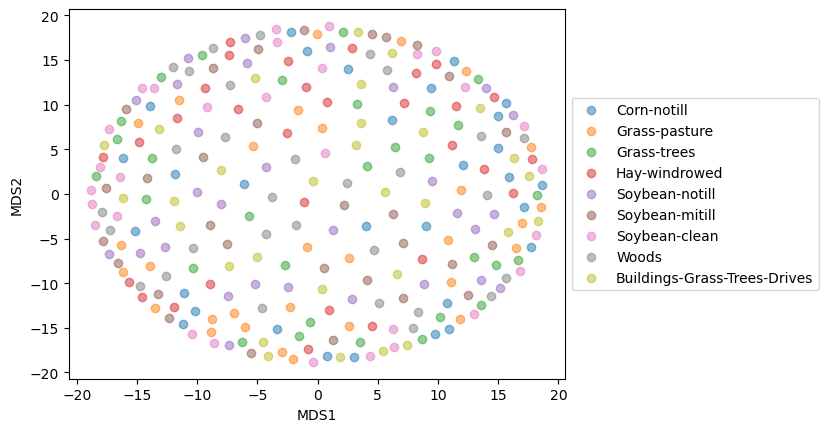

In [107]:

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

n_classes = len(classes)
for i, c in enumerate(classes):
    plt.scatter(vis_data[i*n_pts:(i+1)*n_pts,0],vis_data[i*n_pts:(i+1)*n_pts,1], label = class_names[c], alpha=.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('MDS1')
plt.ylabel('MDS2')

Text(0, 0.5, 't-SNE2')

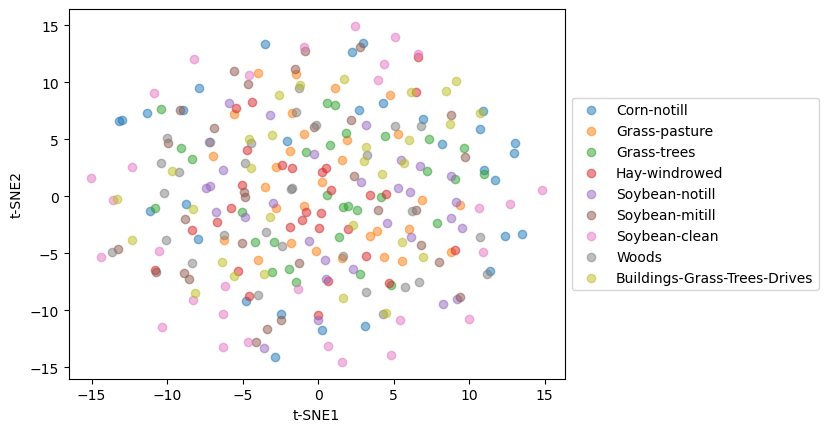

In [108]:

tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
vis_data = tsne.fit_transform(dist_mat)

n_classes = len(classes)
for i, c in enumerate(classes):
    plt.scatter(vis_data[i*n_pts:(i+1)*n_pts,0],vis_data[i*n_pts:(i+1)*n_pts,1], label = class_names[c], alpha=.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

In [109]:
# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)

distance_matrix_train = dist_mat[train_indices,:][:,train_indices]
distance_matrix_test = dist_mat[test_indices,:][:,train_indices]
y_train = mod_labels[train_indices]
y_test = mod_labels[test_indices]

# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)

k=1, Accuracy: 0.1358
k=3, Accuracy: 0.1728
k=5, Accuracy: 0.1728
k=7, Accuracy: 0.1235
